# Natural Language Processing. Assignment 1. Tokenization.

In this assignment, you need to implement, train, and analyze a Byte-Pair Encoding (BPE) tokenizer.

The assignment consist of 3 tasks. When you finish all the tasks, create a GitHub repository for this assignment (you can use this repository later for the other assignments) and submit this notebook in the repository. Leave `requirements.txt` file if your code requires additional installations. Submit the link to the repository in Moodle.

## Task 1: Data Preparation and Vocabulary Size Selection (3 points)

First, load the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus). After loading the corpus, you need to select the appropriate vocabulary size for the BPE tokenizer. The appropriate vocabulary size is the minimal vocabulary size that covers at least 90% of the words in the corpus. The coverage is calculated according to the following formula:



$$ \text{coverage}(k) = \frac{\sum_{r=1}^{k} f(r)}{\sum_{r=1}^{N} f(r)} $$



where $f(r)$ is the frequency of the top-$r$ word, $k$ is the number of top-$k$ tokens included in vocab, $N$ is the total unique words in corpus.

So, for this task you need to do the following:

1. Load the Brown corpus (0.5 points)
2. Plot cumulative coverage vs. vocabulary size for the loaded corpus (1 point)
3. Select the appropriate vocabulary size (0.5 point)
4. Answer the questions:
    1. Why the coverage slows down the increase as the vocabulary size increases? (0.5 point)
    2. Which empirical law explains the slowing down increase of the coverage? (0.5 point)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


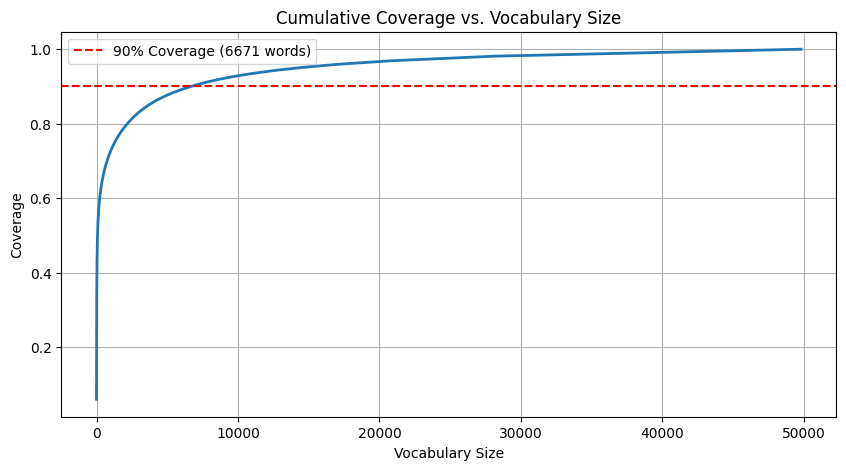

Required dictionary size for 90% coverage: 6671


In [1]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import re

nltk.download('brown')
from nltk.corpus import brown

# Loading and preparing the case
words = [word.lower() for word in brown.words()]
word_counts = Counter(words)
sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Coverage calculation
frequencies = [count for word, count in sorted_counts]
total_words = sum(frequencies)
cumulative_coverage = np.cumsum(frequencies) / total_words

# Finding the dictionary size for 90% coverage
vocab_size_90 = np.where(cumulative_coverage >= 0.9)[0][0] + 1

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(cumulative_coverage, linewidth=2)
plt.axhline(y=0.9, color='r', linestyle='--', label=f'90% Coverage ({vocab_size_90} words)')
plt.title('Cumulative Coverage vs. Vocabulary Size')
plt.xlabel('Vocabulary Size')
plt.ylabel('Coverage')
plt.legend()
plt.grid(True)
plt.show()

print(f"Required dictionary size for 90% coverage: {vocab_size_90}")


1. The coverage grows rapidly at first because the most frequent words (like "the", "of", "and") make up a huge percentage of any English text. Once these top-ranked words are included, we are left with a "long tail" of less frequent words. Adding rare words to the vocabulary increases the vocabulary size significantly but contributes very little to the total text coverage, causing the curve to plateau.


2. This is explained by Zipf's Law. It states that the frequency of any word is inversely proportional to its rank in the frequency table ($f \propto 1/r$). Because the frequency drops off very quickly for lower-ranked words, the marginal gain in coverage diminishes as we expand the vocabulary.

## Task 2: Implement Byte-Pair Encoding (BPE) Tokenizer (4 points)

Implement the [BPE tokenizer](https://arxiv.org/pdf/1508.07909) as the `BPETokenizer` class.

The class should contain correctly implemented:

* `train` method (1.5 points).
* `tokenize` method (1.5 points).

The code should have docstrings and comments (1 point).

In [2]:
import re
from collections import defaultdict, Counter

class BPETokenizer:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.merges = {}  # Rules: pair -> merged_token
        self.ranks = {}   # Optimization: pair -> priority rank
        self.vocab = set()

    def _get_stats(self, word_freqs):
        """Count frequency of all adjacent pairs"""
        pairs = defaultdict(int)
        for word, freq in word_freqs.items():
            symbols = word.split()
            for i in range(len(symbols) - 1):
                pairs[symbols[i], symbols[i+1]] += freq
        return pairs

    def _merge_vocab(self, pair, word_freqs):
        """Merge the most frequent pair in all words"""
        new_word_freqs = {}
        bigram = re.escape(' '.join(pair))
        replacement = ''.join(pair)
        # Regex lookbehind/lookahead ensures we only replace the exact whitespace-separated pair
        pattern = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')

        for word, freq in word_freqs.items():
            new_word = pattern.sub(replacement, word)
            new_word_freqs[new_word] = freq
        return new_word_freqs

    def train(self, corpus):
        """Train BPE on the provided corpus"""
        # Pre-tokenization: basic whitespace split + adding end-of-word token
        # Using a distinct marker usually helps: </w>
        word_freqs = Counter([' '.join(list(word)) + ' </w>' for word in corpus])

        # Initial vocab
        unique_chars = set()
        for word in corpus:
            unique_chars.update(list(word))
        unique_chars.add('</w>')

        current_vocab_size = len(unique_chars)
        num_merges = self.vocab_size - current_vocab_size

        print(f"Initial vocab size: {current_vocab_size}. Target: {self.vocab_size}. Merges needed: {num_merges}")

        for i in range(num_merges):
            stats = self._get_stats(word_freqs)
            if not stats:
                break

            best_pair = max(stats, key=stats.get)

            # Save merge rule
            self.merges[best_pair] = ''.join(best_pair)
            # Assign rank for fast lookup later (lower rank = higher priority)
            self.ranks[best_pair] = i

            word_freqs = self._merge_vocab(best_pair, word_freqs)

            if (i + 1) % 100 == 0:
                print(f"Merges performed: {i+1}")

        self.vocab = set(unique_chars) | set(self.merges.values())

    def _get_bpe_tokens(self, word):
        """Apply BPE merges to a single word"""
        # Initial split into chars
        word_parts = list(word) + ['</w>']

        while len(word_parts) > 1:
            # Find all possible pairs in the current word
            pairs = [(word_parts[i], word_parts[i+1]) for i in range(len(word_parts)-1)]

            # Find the pair with the lowest rank (earliest merge)
            # If a pair is not in self.ranks, it cannot be merged
            best_pair = None
            min_rank = float('inf')

            for pair in pairs:
                if pair in self.ranks:
                    rank = self.ranks[pair]
                    if rank < min_rank:
                        min_rank = rank
                        best_pair = pair

            if best_pair is None:
                break

            # Merge the best pair
            first, second = best_pair
            new_word_parts = []
            i = 0
            while i < len(word_parts):
                # Try to merge at current position
                if i < len(word_parts) - 1 and word_parts[i] == first and word_parts[i+1] == second:
                    new_word_parts.append(first + second)
                    i += 2
                else:
                    new_word_parts.append(word_parts[i])
                    i += 1
            word_parts = new_word_parts

        return word_parts

    def tokenize(self, text):
        """Tokenize text using trained BPE merges"""
        # Simple whitespace pre-tokenization
        words = text.lower().split()
        final_tokens = []

        for word in words:
            final_tokens.extend(self._get_bpe_tokens(word))

        return final_tokens


## Task 3: Tokenizer Training and Analysis (3 points)

1. Train the `BPETokenizer` on the Brown corpus with the appropriate vocabulary size selected in Task 1 (1 points)
2. Use the Brown corpus (1000 samples) to calculate the mean and standard deviation of
    * tokenizer's fertility (1 points)
    * length of the tokenized sentence (1 points)

In [3]:
import numpy as np

# 1. Prepare Training Data
# We use the full Brown corpus (or a large subset) to ensure good coverage.
# The optimized BPETokenizer can handle the full corpus reasonably fast.
print("Preparing training data...")
train_data = [word.lower() for word in brown.words()]

# Initialize the tokenizer using the vocabulary size calculated in Task 1
# Note: 'vocab_size_90' must be defined in previous cells
tokenizer = BPETokenizer(vocab_size=vocab_size_90)

# Train the model
print(f"Starting BPE training with target vocab size: {vocab_size_90}...")
tokenizer.train(train_data)

# 2. Evaluation
# We evaluate the tokenizer on the first 1000 sentences of the Brown corpus
test_sents = brown.sents()[:1000]
fertilities = []
lengths = []

print("\nStarting evaluation on 1000 test sentences...")

for sent in test_sents:
    # Reconstruct the sentence string from tokens (simple space joining)
    text = " ".join(sent)

    # Tokenize using our trained BPE model
    tokens = tokenizer.tokenize(text)

    # Calculate Fertility:
    # Fertility = (number of BPE tokens) / (number of original words)
    # A lower fertility (closer to 1.0) indicates the tokenizer splits words less often.
    current_fertility = len(tokens) / len(sent)
    fertilities.append(current_fertility)

    # Record the total number of tokens in the sentence
    lengths.append(len(tokens))

# 3. Report Results
# Displaying mean and standard deviation for both metrics as required
print("\n" + "="*45)
print(f" Evaluation Results (Vocab Size: {vocab_size_90})")
print("="*45)
print(f"Mean Fertility:       {np.mean(fertilities):.4f}")
print(f"Std Fertility:        {np.std(fertilities):.4f}")
print("-" * 45)
print(f"Mean Sentence Length: {np.mean(lengths):.2f}")
print(f"Std Sentence Length:  {np.std(lengths):.2f}")
print("="*45)


Preparing training data...
Starting BPE training with target vocab size: 6671...
Initial vocab size: 58. Target: 6671. Merges needed: 6613
Merges performed: 100
Merges performed: 200
Merges performed: 300
Merges performed: 400
Merges performed: 500
Merges performed: 600
Merges performed: 700
Merges performed: 800
Merges performed: 900
Merges performed: 1000
Merges performed: 1100
Merges performed: 1200
Merges performed: 1300
Merges performed: 1400
Merges performed: 1500
Merges performed: 1600
Merges performed: 1700
Merges performed: 1800
Merges performed: 1900
Merges performed: 2000
Merges performed: 2100
Merges performed: 2200
Merges performed: 2300
Merges performed: 2400
Merges performed: 2500
Merges performed: 2600
Merges performed: 2700
Merges performed: 2800
Merges performed: 2900
Merges performed: 3000
Merges performed: 3100
Merges performed: 3200
Merges performed: 3300
Merges performed: 3400
Merges performed: 3500
Merges performed: 3600
Merges performed: 3700
Merges performed: 3

## Grading Procedure Details

During the grading of the completed assignments, a random set of students will be sampled for the **offline assignment defence**. The defence will be arranged shortly after the assignment submission deadline. The particular date and time will be announced later.

The aim of the assignment defence is to ensure the students understand well their own solutions and know how thier solution works. To check this, the students will be asked various questions about the provided solution. In addition, the students will be asked to run their solution to ensure the solution works without errors.

Examples of questions:

1. How the cumulative coverage is calculated? Why is it called cumulative?
2. What is the rank of a word?
3. How does the BPE tokenizer work? Note: for this question, the students will not be able to see the their own implementation.
4. Why do you consider such vocabulary size appropriate?
5. What is the formula for the fertility of the tokenizer?
6. How do you perform pre-tokenization in your implementation?
7. How do you handle stopwords in the training corpus? Why?
8. etc.

As a result of the assignment defence, the grade for the assignment may be adjusted.